In [1]:
import argparse
import logging
import multiprocessing as mp
import os
import random as rn
import warnings
from pathlib import Path
from shlex import split
from subprocess import Popen, PIPE, STDOUT
from tempfile import mkstemp

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
from IPython.display import display
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.preprocessing import Normalizer

seed = 42
sns.set()

def reset_seed():
    os.environ["PYTHONHASHSEED"] = str(seed)
    rn.seed(seed)
    np.random.seed(seed)

Index(['timeStamp', 'demand', 'precip', 'temp'], dtype='object')
(1000, 4) 0
(1000, 2) 0


,timeStamp,demand
0,2012-01-01 00:00:00,4937.5
1,2012-01-01 01:00:00,4752.1
2,2012-01-01 02:00:00,4542.6
3,2012-01-01 03:00:00,4357.7
4,2012-01-01 04:00:00,4275.5
...,...,...
995,2012-02-11 11:00:00,5841.7
996,2012-02-11 12:00:00,5882.4
997,2012-02-11 13:00:00,5888.5
998,2012-02-11 14:00:00,5873.8


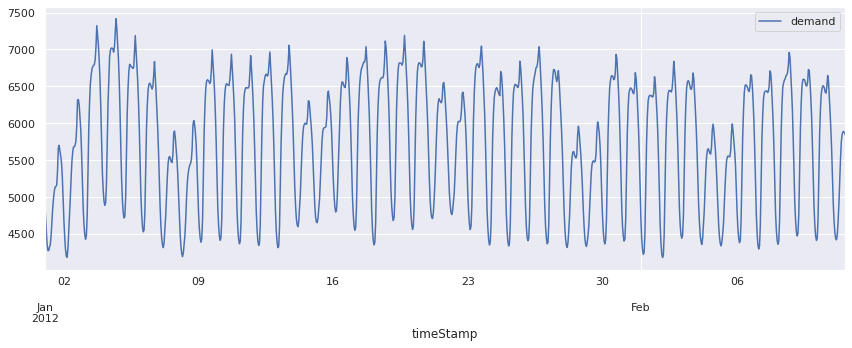

In [2]:
data_path = "data/nyc_energy.csv"
data = pd.read_csv(data_path)[:-81][:1000]
dt, target = "timeStamp", "demand"
print(data.columns)
print(data.shape, data[target].isna().sum())

data[dt] = pd.to_datetime(data[dt])
data = data.set_index(dt)
data = data[[target]]
data = data.resample("h").mean().interpolate()
data = data.reset_index()

print(data.shape, data[target].isna().sum())
display(data)
data.plot(x=dt, y=target, figsize=(12, 5))
plt.tight_layout()
plt.show()

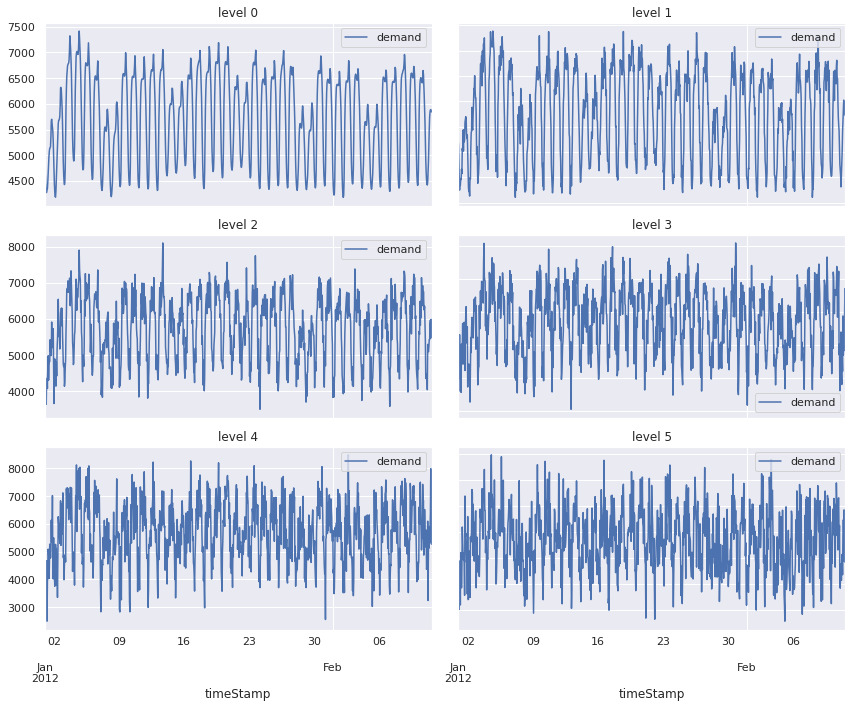

In [3]:
reset_seed()

train_dfs, test_dfs, pred_dfs = dict(), dict(), dict()
target_std = data[target].std()
data_fault_params = dict(zip(np.arange(6), target_std * np.linspace(0, 1, num=6)))

fig, axes = plt.subplots(3, 2, figsize=(12, 10))
for i, ax in zip(data_fault_params.keys(), axes.flatten()):
    data_ = data.copy()
    data_[target] += np.random.normal(scale=data_fault_params[i], size=len(data))
    data_.plot(x=dt, y=target, ax=ax, sharex=True, sharey=True, title=f"level {i}")
    
    x_train, x_test, y_train, y_test = train_test_split(data_[dt].values, data_[target].values,
                                                        shuffle=False, test_size=.2)
    train_dfs[i] = pd.DataFrame({dt: x_train, target: y_train})
    test_dfs[i] = pd.DataFrame({dt: x_test, target: y_test})
    path = f"train/{Path(data_path).stem}_noise_level_{i}.csv"
    if not Path(path).exists():
        train_dfs[i].to_csv(path, index=False)
plt.tight_layout()
plt.show()

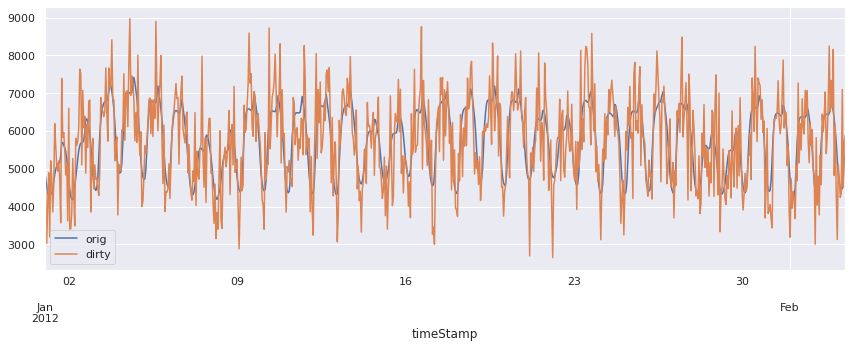

In [4]:
df_orig = train_dfs[0]
df_dirty = train_dfs[5]
df = pd.DataFrame({dt: df_orig[dt], "orig": df_orig[target], "dirty": df_dirty[target]})
df.plot(x=dt, figsize=(12, 5))
plt.tight_layout()
plt.show()

In [ ]:
# def setup_logging(log_path, log_lvl="INFO"):
#     logging.basicConfig(level=getattr(logging, log_lvl.upper()),
#                         format="%(asctime)s: [%(levelname)s] %(message)s",
#                         handlers=[logging.FileHandler(filename=log_path, mode="w",
#                                                       encoding="utf-8")])

def run_cmd(cmd, log_path):
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    fh = logging.FileHandler(filename=log_path, mode="w", encoding="utf-8")
    fh.setLevel(logging.INFO)
    formatter = logging.Formatter("%(asctime)s: [%(levelname)s] %(message)s")
    fh.setFormatter(formatter)
    logger.addHandler(fh)

    p = Popen(split(cmd), bufsize=1, stdout=PIPE, stderr=STDOUT, universal_newlines=True)
    while True:
        out = p.stdout.readline().strip()
        if len(out) == 0 and p.poll() is not None:
            break
        logger.info(out)
    code = p.returncode
    if code != 0:
        logger.error("")
    return code

automl_names = ["analytics-zoo", "azure_automl", "tpot_automl"]
for automl_name in automl_names:
    pred_dfs[automl_name] = dict()
    for i in range(len(data_fault_params)):
        train_path = f"train/{Path(data_path).stem}_noise_level_{i}.csv"
        log_path = mkstemp(prefix=f"{Path(data_path).stem}_noise_level_{i}_{automl_name}_",
                           suffix=".txt", dir="logs", text=True)[1]
        pred_path = f"pred/{Path(data_path).stem}_noise_level_{i}_{automl_name}.csv"
        if not Path(pred_path).exists():
            cmd = f"conda run -n {automl_name} python {automl_name}.py {train_path} " \
                  f"{pred_path} {len(test_dfs[i])} {dt} {target}"
            print(f"[cmd] {cmd}")
            if run_cmd(cmd, log_path) == 0:
                print("ok")
            else:
                raise SystemExit("FAIL")
        df_pred = pd.read_csv(pred_path)
        df_pred[dt] = pd.to_datetime(df_pred[dt])
        pred_dfs[automl_name][i] = df_pred

[cmd] conda run -n azure_automl python azure_automl.py train/nyc_energy_noise_level_2.csv pred/nyc_energy_noise_level_2_azure_automl.csv 200 timeStamp demand
ok
[cmd] conda run -n azure_automl python azure_automl.py train/nyc_energy_noise_level_3.csv pred/nyc_energy_noise_level_3_azure_automl.csv 200 timeStamp demand
ok
[cmd] conda run -n azure_automl python azure_automl.py train/nyc_energy_noise_level_4.csv pred/nyc_energy_noise_level_4_azure_automl.csv 200 timeStamp demand
ok
[cmd] conda run -n azure_automl python azure_automl.py train/nyc_energy_noise_level_5.csv pred/nyc_energy_noise_level_5_azure_automl.csv 200 timeStamp demand


In [ ]:
df_test = test_dfs[0]
metrics = []
for automl_name in automl_names:
    fig, axes = plt.subplots(3, 2, figsize=(12, 10))
    for i, ax in zip(data_fault_params.keys(), axes.flatten()):
        df_pred = pred_dfs[automl_name][i]
        rmse = np.round(np.sqrt(mean_squared_error(df_test[target], df_pred[target])), decimals=3)
        r2 = np.round(r2_score(df_test[target], df_pred[target]), decimals=3)
        metrics.append({"metric": "RMSE", "automl_name": automl_name, "level": i, "score": rmse})
        metrics.append({"metric": "R^2", "automl_name": automl_name, "level": i, "score": r2})
        df = pd.DataFrame({dt: df_test[dt], "test": df_test[target], "pred": df_pred[target]})
        df.plot(x=dt, ax=ax, sharex=True, sharey=True, title=f"level {i} | RMSE {rmse} | R^2 {r2}")
    plt.tight_layout()
    plt.show()

In [ ]:
df_metrics = pd.DataFrame(metrics)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax, metric in zip(axes.flatten(), ["RMSE", "R^2"]):
    df = df_metrics[df_metrics["metric"] == metric]
    df = df.groupby(["level", "automl_name"])["score"].aggregate("first").unstack()
    df.columns.name = None
    df.plot(ax=ax, title=metric)
plt.tight_layout()
plt.show()